
<hr>

# Linear regression - iterative solution

### Objectives:

- to implement and test the iterative solution for the linear regression task
- to understand the core idea of gradient descent based function optimization

<hr>

## For this EP we will use automatic testing

After every task, you will see a test cell to check your solution. We encourage you to experiment with these values to ensure your code is correct

### Plotting

Auxiliary function to plot the loss through the gradient steps

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simple_step_plot(ylist, yname, title, figsize=(4, 4), labels=None):
    y0 = ylist[0]
    x = np.arange(1, len(y0) + 1, 1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for y in ylist:
        ax.plot(x, y)
    plt.xlabel('step')
    plt.ylabel(yname)
    plt.title(title,
              fontsize=14,
              fontweight='bold')
    plt.grid(True)
    if labels is not None:
        plt.legend(labels,
           loc='upper right')
    plt.show()

### Getting the data for the problem:

We will use the same dataset as the EP1!

The *Boston Housing Dataset*. See a description of the dataset at https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html. The dataset was downloaded from Kaggle (file HousingData.csv)


In [19]:
df=pd.read_csv('HousingData.csv')

# We fill in the missing data with the average value of the respective column. Since our aim in this EP
# is to learn the linear regression algorithm, we will not discuss whether this decision is adequate or not.

df = df.fillna(df.mean())
df.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.545770   22.921051    6.699165    0.250233    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.083235    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.290250    0.000000    9.900000    0.000000    0.538000    6.208500   
75%      3.611874   11.211934   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.518519    3.795043    9.549407  408.237154   18.455534  356.674032   
std     27.439466    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.925000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     74.450000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     93.575000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT        MEDV  
count  506.000000  506.000000  
mean    12.715432   22.532806  
std      7.012739    9.197104  
min      1.730000    5.000000  
25%      7.230000   17.025000  
50%     11.995000   21.200000  
75%     16.570000   25.000000  
max     37.970000   50.000000

### Data Normalization

Data standardization is important in machine learning for several reasons:

- Numerical stability - Large diferences in feature scales can lead  to unstable and inaccurate regression coefficients

- Faster convergence - Gradient descent converge faster when features are on a similar scale

- Prevents bias in coefficients - Without normalization, features with larger magnitudes may dominate the model

While not always necessary for simple linear regression, normalization is highly recommended for gradient-based optimization

There are many ways to normalize your data, see [Data Normalization](https://learn.microsoft.com/en-us/azure/machine-learning/component-reference/normalize-data?view=azureml-api-2)


In [20]:
# we apply z-score on each column
df=(df-df.mean())/df.std()
df.describe()

CRIM            ZN         INDUS          CHAS           NOX  \
count  5.060000e+02  5.060000e+02  5.060000e+02  5.060000e+02  5.060000e+02   
mean  -5.616939e-17 -9.127525e-17 -1.263811e-16  1.404235e-17 -1.404235e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -4.219109e-01 -4.891544e-01 -1.585868e+00 -2.795747e-01 -1.464433e+00   
25%   -4.129106e-01 -4.891544e-01 -8.798099e-01 -2.795747e-01 -9.121262e-01   
50%   -3.886863e-01 -4.891544e-01 -1.767372e-01 -2.795747e-01 -1.440749e-01   
75%   -5.196597e-17 -7.749892e-17  1.047296e+00 -2.795747e-01  5.980871e-01   
max    9.989073e+00  3.873647e+00  2.486281e+00  3.716698e+00  2.729645e+00   

                 RM           AGE           DIS           RAD           TAX  \
count  5.060000e+02  5.060000e+02  5.060000e+02  5.060000e+02  5.060000e+02   
mean  -9.829643e-17  4.774398e-16 -1.123388e-16  1.123388e-16  5.616939e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.876413e+00 -2.391392e+00 -1.265817e+00 -9.818712e-01 -1.312691e+00   
25%   -5.680681e-01 -8.233950e-01 -8.048913e-01 -6.373311e-01 -7.668172e-01   
50%   -1.083583e-01  2.161661e-01 -2.790473e-01 -5.224844e-01 -4.642132e-01   
75%    4.822906e-01  9.131548e-01  6.617161e-01  1.659603e+00  1.529413e+00   
max    3.551530e+00  1.147307e+00  3.956602e+00  1.659603e+00  1.796416e+00   

            PTRATIO             B         LSTAT          MEDV  
count  5.060000e+02  5.060000e+02  5.060000e+02  5.060000e+02  
mean  -3.370163e-16 -7.021173e-16 -1.263811e-16 -5.336092e-16  
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
min   -2.704703e+00 -3.903331e+00 -1.566497e+00 -1.906340e+00  
25%   -4.875567e-01  2.048688e-01 -7.822097e-01 -5.988631e-01  
50%    2.745872e-01  3.808097e-01 -1.027319e-01 -1.449159e-01  
75%    8.057784e-01  4.332223e-01  5.496523e-01  2.682577e-01  
max    1.637208e+00  4.406159e-01  3.601242e+00  2.986505e+00

Here we select the dependent variables (features) to run the model and plotting the relationship between them and the independent variable (Median Value in $1000 -- `MEDV`)

X shape:  (506, 2)
y shape:  (506, 1)


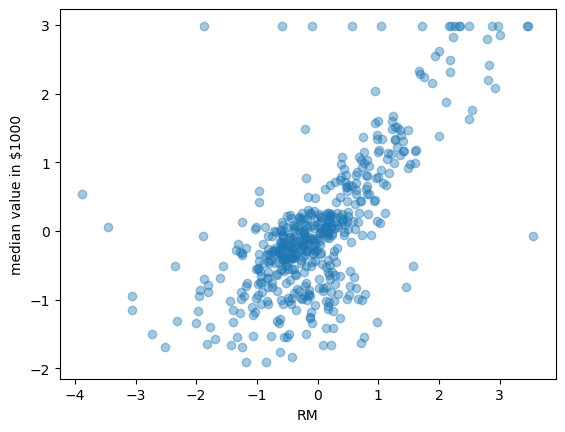

In [21]:
# Features: CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT

colname = 'RM'
X = df.loc[:, colname]
X = X.to_numpy().reshape(-1,1)
X = np.concatenate([np.ones((len(X), 1)), X], axis = 1)  # data matrix, with left column of ONEs

y = df.loc[:, 'MEDV']
y = y.to_numpy()
y = y.reshape((-1,1))

print("X shape: ", X.shape)
print("y shape: ", y.shape)

plt.scatter(X[:,1], y, alpha=0.4)
plt.xlabel(colname)
plt.ylabel('median value in $1000')

plt.show()



# Gradient Descent Recap

The gradient vector is a vector normal to the contour of a function at a given point, indicating the direction and sense in which the point should be moved to maximize the function's value. Consequently, the negative of this vector points in the direction and sense of the greatest decrease.

The main idea of the Gradient Descent algorithm is to choose a vector $w$, initially with arbitrary values, and at each iteration $t$, update it by a small fraction $\eta$ (**learning rate**) in the opposite direction of the gradient of the Loss Function, for a predefined number of iterations called **epochs**.

$$ w(t + 1) = w(t) - \eta \nabla \mathscr{L}(w) $$


<div align="center">
  <img src="https://i.imgur.com/dlZ3GPz.jpeg" alt="Image description" width="200">
  <p>Figure 1: Loss Function optimization</p>
</div>

For linear regression we use the Mean Squared Error as loss function

$$MSE = \frac{1}{N} \sum_{i = 1}^{N} (\hat{y}^{(i)} - y^{(i)})^{2} $$

### Iterative Solution

Let's calculate MSE's gradient

$$\nabla MSE = \Big[ \frac{\partial MSE}{\partial w_1}, \frac{\partial MSE}{\partial w_2}, \dots, \frac{\partial MSE}{\partial w_d} \Big] ^{T}$$

where

$$
\begin{split}
  \frac{\partial MSE}{\partial w_j} & = \frac{\partial}{\partial w_j} \Big[ \frac{1}{N} \sum_{i = 1}^{N} (\hat{y}^{(i)} - y^{(i)})^{2} \Big]\\
                                    & = \frac{1}{N} \sum_{i = 1}^{N} 2(\hat{y}^{(i)} - y^{(i)}) \frac{\partial}{\partial w_j} (\hat{y}^{(i)} - y^{(i)}) \\
                                    & = \frac{2}{N} \sum_{i = 1}^{N} (\hat{y}^{(i)} - y^{(i)}) \frac{\partial}{\partial w_j} \big((w_0 + w_1x_{1}^{(i)} + ... + w_jx_{j}^{(i)} + ... + w_dx_{d}^{(i)}) - y^{(i)}\big) \\
                                    & = \frac{2}{N} \sum_{i = 1}^{N} (\hat{y}^{(i)} - y^{(i)})x_{j}^{(i)}
\end{split}
$$

Thus

$$\nabla MSE = \frac{2}{N} X^T \boldsymbol{\cdot} (\hat{y} - y)$$

With the gradient of the loss function calculated you can use the Gradient Descent to find its optimal value

### <mark>1. Write the function that computes the cost</mark>

In [22]:
def compute_cost(X, y, w):
    """
    Calculates  mean square error cost.

    :param X: data matrix
    :type X: np.ndarray(shape=(N, 1+d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(1+d, 1))
    :return: cost
    :rtype: float
    """
    N = X.shape[0]
    y_hat = X @ w
    cost = (1/N) * np.sum((y_hat-y) ** 2)
    return cost

    

In [23]:
X_test = np.array([[1, 2], [1, 3], [1, 4]])
y_test = np.array([[3], [5], [7]])
w_test = np.array([[1], [2]])
expected_cost = 4.0
assert np.isclose(compute_cost(X_test, y_test, w_test), expected_cost), "Test failed for compute_cost"


### <mark>2. Write the function that computes the gradient of the cost function</mark>

In [24]:
def compute_wgrad(X, y, w):
    """
    Calculates gradient of J(w) with respect to w.

    :param X: data matrix
    :type X: np.ndarray(shape=(N, 1+d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(1+d, 1))
    :return: gradient
    :rtype: np.array(shape=(1+d, 1))
    """
    N = X.shape[0]
    y_hat = X @ w
    wgrad = (2/N) * X.T @ (y_hat - y)
    return wgrad


In [25]:
X_test = np.array([[1, 2], [1, 3], [1, 4]])
y_test = np.array([[3], [5], [7]])
w_test = np.array([[1], [2]])
expected_grad = np.array([[4.], [12.]])
assert np.allclose(compute_wgrad(X_test, y_test, w_test), expected_grad), "Test failed for compute_wgrad"


### <mark>3. Write the function that optmizes the cost function</mark>

In [26]:
# Optimization of the cost function:
# application of the gradient descent technique
# The function must return not only the final weights
# but also a list with the weight vectors computed
# along the iterations. Same for the costs computed along
# the iterations

def batch_gradient_descent(X, y, w, learning_rate=0.001, num_iters=100):
    """
     Performs batch gradient descent optimization.

    :param X: data matrix
    :type X: np.ndarray(shape=(N, 1+d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(1+d, 1))
    :param learning_rate: learning rate
    :type learning_rate: float
    :param num_iters: number of iterations
    :type num_iters: int
    :return: weights, weight history, cost history
    :rtype: np.array(shape=(1+d, 1)), list, list
    """

    w_current = w

    cost_history = [compute_cost(X, y, w)]
    w_history = [w_current]

    for t in range(0, num_iters):
        wgrad = compute_wgrad(X, y, w_current)
        w_current = w_current - learning_rate*wgrad
        w_history.append(w_current.copy())
        cost_history.append(compute_cost(X, y, w_current))    

    return w_current, w_history, cost_history

In [27]:
X_test = np.array([[1, 2], [1, 3], [1, 4]])
y_test = np.array([[3], [5], [7]])
w_test = np.array([[0], [0]])
learning_rate = 0.1
num_iters = 10

w_final, w_history, cost_history = batch_gradient_descent(X_test, y_test, w_test, learning_rate, num_iters)

expected_w_final = np.array([[-1.19754351], [-3.21543396]])
expected_cost_history_length = num_iters + 1

assert np.allclose(w_final, expected_w_final, atol=1e-1), "Test failed for batch_gradient_descent: w_final incorrect"
assert len(cost_history) == expected_cost_history_length, "Test failed for batch_gradient_descent: cost history length incorrect"


### <mark>4. Write the function that computes the prediction</mark>

In [28]:
def compute_prediction(X, w):
    """
    Calculates the prediction over a set of observations X using
    the linear function characterized by the weight vector w.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, 1+d))
    :param w: weight vector
    :type w: np.ndarray(shape=(1+d, 1))
    :param y: regression prediction
    :type y: np.ndarray(shape=(N, 1))
    """

    return X @ w


In [29]:
X_test = np.array([[1, 2], [1, 3], [1, 4]])
w_test = np.array([[1], [2]])
expected_prediction = np.array([[5], [7], [9]])

assert np.allclose(compute_prediction(X_test, w_test), expected_prediction), "Test failed for compute_prediction"


Here is the code that will actually run the linear regression task to obtain the optimized model parameters


In [30]:
from sklearn.metrics import r2_score

initial_w = np.array([[0], [1]])
print("Initial weight:\n", initial_w)

learning_rate = 0.001
iterations = 5000

w, w_history, cost_history = batch_gradient_descent(X, y, initial_w, \
                                         learning_rate, iterations)


print("Final weight:\n", w)

prediction = compute_prediction(X,w)
mse = ((y - prediction)**2).mean(axis=0).item()
r_2 = r2_score(y, prediction)

print("MSE = %f" %(mse))
print("R2 = ", r_2)

Initial weight:
 [[0]
 [1]]
Final weight:
 [[-4.73455476e-16]
 [ 6.95373914e-01]]
MSE = 0.515454
R2 =  0.4835254557962657


### Now plotting the training loss

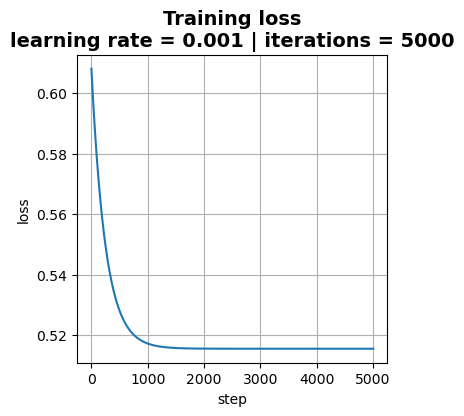

In [31]:
simple_step_plot(
    [cost_history], 'loss',
    'Training loss\nlearning rate = {} | iterations = {}'.format(learning_rate, iterations))

### Finally, we plot the obtained line:

-3.876413225718594 3.5515296431831955


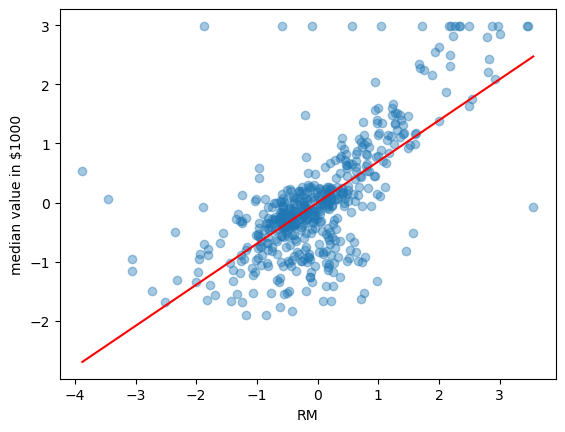

In [32]:
plt.scatter(X[:,1], y, alpha=0.4)
min = np.min(X[:,1])
max = np.max(X[:,1])
print(min,max)
x_reg = np.linspace(min,max, 100)
y_reg = w[1]*x_reg + w[0]
plt.plot(x_reg, y_reg, c='r')
plt.xlabel(colname)
plt.ylabel('median value in $1000')
plt.show()

# Visualization of the iterative solution

As the name says, an iterative solution assumes different values through the core loop of the program. That means that two iterations may differ in regards to what line they are able produce.

With Gradient Descent algorithm, as explained earlier, we are trying to "walk" through the landscape of the function in the direction that minimizes this function.

Below, we offer you two cells of code that allow you to visualize the journey that the algorithm is taking while trying to get to the best solution.

## Snapshots of the iterative process

This first cell should show a gallery of snapshots of all the regression lines generated through the iterations, that you can examine. For example, if you choose 1000 on the slider below, you will be looking at which line the algorithm generated at iteration 1000.


In [33]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random

# This parameter decides how many interations of Gradient Descent should be plotted
n_start=1
n_steps = iterations
@interact(step=(n_start,n_steps,1), X=fixed(X), w=fixed(w_history), y=fixed(y))
def plot_line(step, X, w, y):

  fig, ax = plt.subplots()
  ax.set_xlim([-4.5, 4.5])
  ax.set_ylim([-3.5, 3.5])
  ax.scatter(X[:,1], y, label="Actual Data", alpha=0.4)
  line_points = compute_prediction(X, w[step])
  plt.plot(X[:,1], line_points, color="red", label="Optimized Line (With GD)")
  plt.xlabel("Feature")
  plt.ylabel("Target")
  plt.title("Linear Regression With Gradient Descent")
  ax.legend()

  return ()

interactive(children=(IntSlider(value=2500, description='step', max=5000, min=1), Output()), _dom_classes=('wi…

## Animation of the iterative solution

The last cell is this notebook is to show you how the evolution of the system happens in a video form. As you saw in the last cell, the iteration process goes through multiple different lines that try to explain the data. In the animation, it's possible to see the "direction" that the system are evolving in order to arrive at the regression line that explains the data the best.

You may experience the appearance of a standalone graph after the animation widget in your notebook. This is an error generated by the interaction between matplotlib and jupyter notebook and it is just the first frame of the animation. You can disregard it.


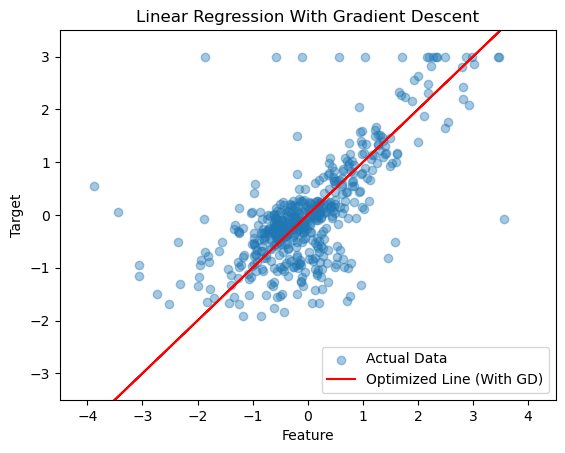

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import matplotlib.animation as animation

rc('animation', html='jshtml')

fig, ax = plt.subplots();

scat = ax.scatter(X[:, 1], y, label="Actual Data", alpha=0.4);
line_points = compute_prediction(X, w_history[0])
cur_line = ax.plot(X[:, 1], line_points, c="red", label="Optimized Line (With GD)")[0];

ax.set_xlim([-4.5, 4.5])
ax.set_ylim([-3.5, 3.5])
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("Linear Regression With Gradient Descent")
ax.legend()

# using 100 frames for the animation because of memory issues (would have to store 5000 pictures in memory)
# change the following parameter to change how many iterations are plotted in the animation
n_frames = 100

# change 'step' keyword argument below to change the rate of evolution of the line
def update(frame, step=25):
    # update the line plot:
    line_points = compute_prediction(X, w_history[step*frame])
    cur_line.set_ydata(line_points)

    return scat, cur_line

ani = animation.FuncAnimation(fig=fig, func=update, frames=n_frames, interval=60);
ani

# 5. <mark>Input with $d=2$ features</mark>

Now, write the code that builds a new X dataset consisting of features 'RM' and 'LSTAT' and runs the linear regression task to obtain the optimized model parameters. Print the weight vector, and the MSE and R2 score.

In [36]:
# Build the new X dataset
colnames = ['RM', 'LSTAT']
X = df.loc[:, colnames]
X = X.to_numpy()
X = np.concatenate([np.ones((len(X), 1)), X], axis = 1)  # data matrix, with left column of ONEs

y = df.loc[:, 'MEDV']
y = y.to_numpy()
y = y.reshape((-1,1))

print("X shape: ", X.shape)
print("y shape: ", y.shape)


# Initialize the initial_w weight vector
initial_w = np.array([[0], [1], [1]])

print("Initial weight:\n", initial_w)

learning_rate = 0.001
iterations = 5000

# RUN the optimization algorithm
w, w_history, cost_history = batch_gradient_descent(X, y, initial_w, \
                                         learning_rate, iterations)

print("Final weight:\n", w)

# Compute the prediction, MSE and R2 score
prediction = compute_prediction(X,w)
mse = ((y - prediction)**2).mean(axis=0).item()
r_2 = r2_score(y, prediction)

print("MSE = %f" %(mse))
print("R2 = ", r_2)

X shape:  (506, 3)
y shape:  (506, 1)
Initial weight:
 [[0]
 [1]
 [1]]
Final weight:
 [[-5.46827340e-16]
 [ 4.28203355e-01]
 [-4.55993770e-01]]
MSE = 0.372075
R2 =  0.6271879685246755
